## **Install External Library**

In [1]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.7 MB/s eta 0:00:00


In [3]:
!pip install kaggle
!chmod 600 /root/.config/kaggle/kaggle.json

## **Import Library**

In [50]:
# Library standar
import os
import time
import joblib
import requests
from io import BytesIO

# Library analisis data & visualisasi
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn: preprocessing, model, evaluasi
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Optimisasi model
from skopt import BayesSearchCV

# Penanganan data tidak seimbang
from imblearn.over_sampling import SMOTE

# TensorFlow dan Keras
import tensorflow as tf
from tensorflow.keras import layers, models

## **Data Collecting**

In [4]:
!kaggle datasets list -s "Stroke Diagnosis and Health Metrics Data"

ref                                                      title                                           size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  ----------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
shriyashjagtap/stroke-diagnosis-and-health-metrics-data  Stroke Diagnosis and Health Metrics Data      314199  2025-02-14 03:55:45.980000            647          9  1.0              
denvirgama/heart-disease                                 Heart Disease                                3165801  2024-12-08 06:11:35.253000             70          1  0.5294118        
steventuschman/metabolic-health-calculator               Metabolic Health Calculator                     3786  2024-07-09 19:53:39.420000             26          1  0.4375           


In [5]:
!kaggle datasets download -d "shriyashjagtap/stroke-diagnosis-and-health-metrics-data" --force
!unzip stroke-diagnosis-and-health-metrics-data.zip

Dataset URL: https://www.kaggle.com/datasets/shriyashjagtap/stroke-diagnosis-and-health-metrics-data
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/307k [00:00<?, ?B/s]
100% 307k/307k [00:00<00:00, 452MB/s]
Archive:  stroke-diagnosis-and-health-metrics-data.zip
  inflating: stroke_data.csv         


## **Data Loading**

In [6]:
data = pd.read_csv("/content/stroke_data.csv")
data.head()

,Age,Gender,SES,Hypertension,Heart_Disease,BMI,Avg_Glucose,Diabetes,Smoking_Status,Stroke
0,66.788137,Male,Medium,1,0,25.842521,96.428681,1,Current,1
1,86.393609,Female,Medium,1,1,32.531061,133.350068,0,Never,1
2,76.158579,Female,Medium,1,0,40.681244,111.489589,0,Never,0
3,72.477870,Female,Low,0,1,33.003193,125.692465,0,Former,0
4,59.881635,Male,Low,0,0,26.062443,123.218486,1,Never,1


In [7]:
# Menampilkan ringkasan informasi dari dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             10000 non-null  float64
 1   Gender          10000 non-null  object 
 2   SES             10000 non-null  object 
 3   Hypertension    10000 non-null  int64  
 4   Heart_Disease   10000 non-null  int64  
 5   BMI             10000 non-null  float64
 6   Avg_Glucose     10000 non-null  float64
 7   Diabetes        10000 non-null  int64  
 8   Smoking_Status  10000 non-null  object 
 9   Stroke          10000 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [8]:
# Cek missing values
print("\nMissing values per fitur:")
print(data.isnull().sum())


Missing values per fitur:
Age               0
Gender            0
SES               0
Hypertension      0
Heart_Disease     0
BMI               0
Avg_Glucose       0
Diabetes          0
Smoking_Status    0
Stroke            0
dtype: int64


## **Exploratory Data Analysis (EDA)**

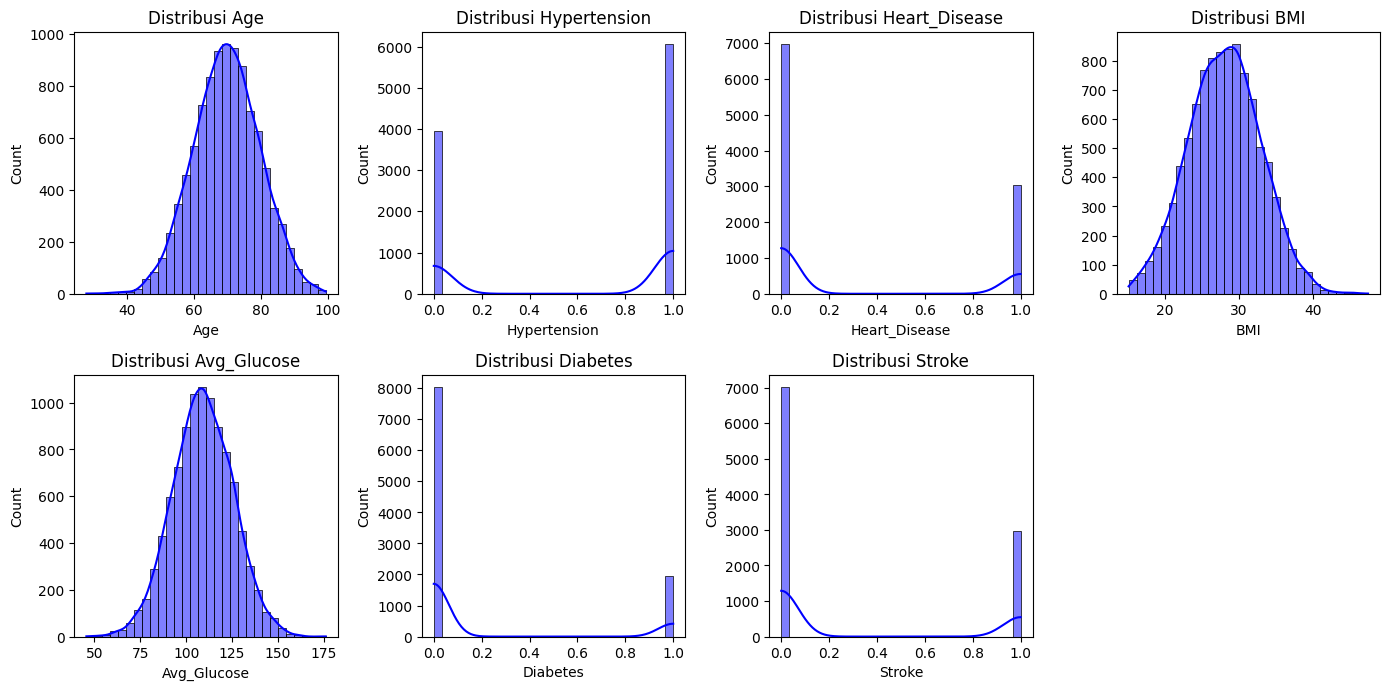

In [9]:
# Distribusi fitur numerik
num_features = data.select_dtypes(include=[np.number])
plt.figure(figsize=(14, 10))
for i, column in enumerate(num_features.columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(data[column], bins=30, kde=True, color='blue')
    plt.title(f'Distribusi {column}')
plt.tight_layout()
plt.show()

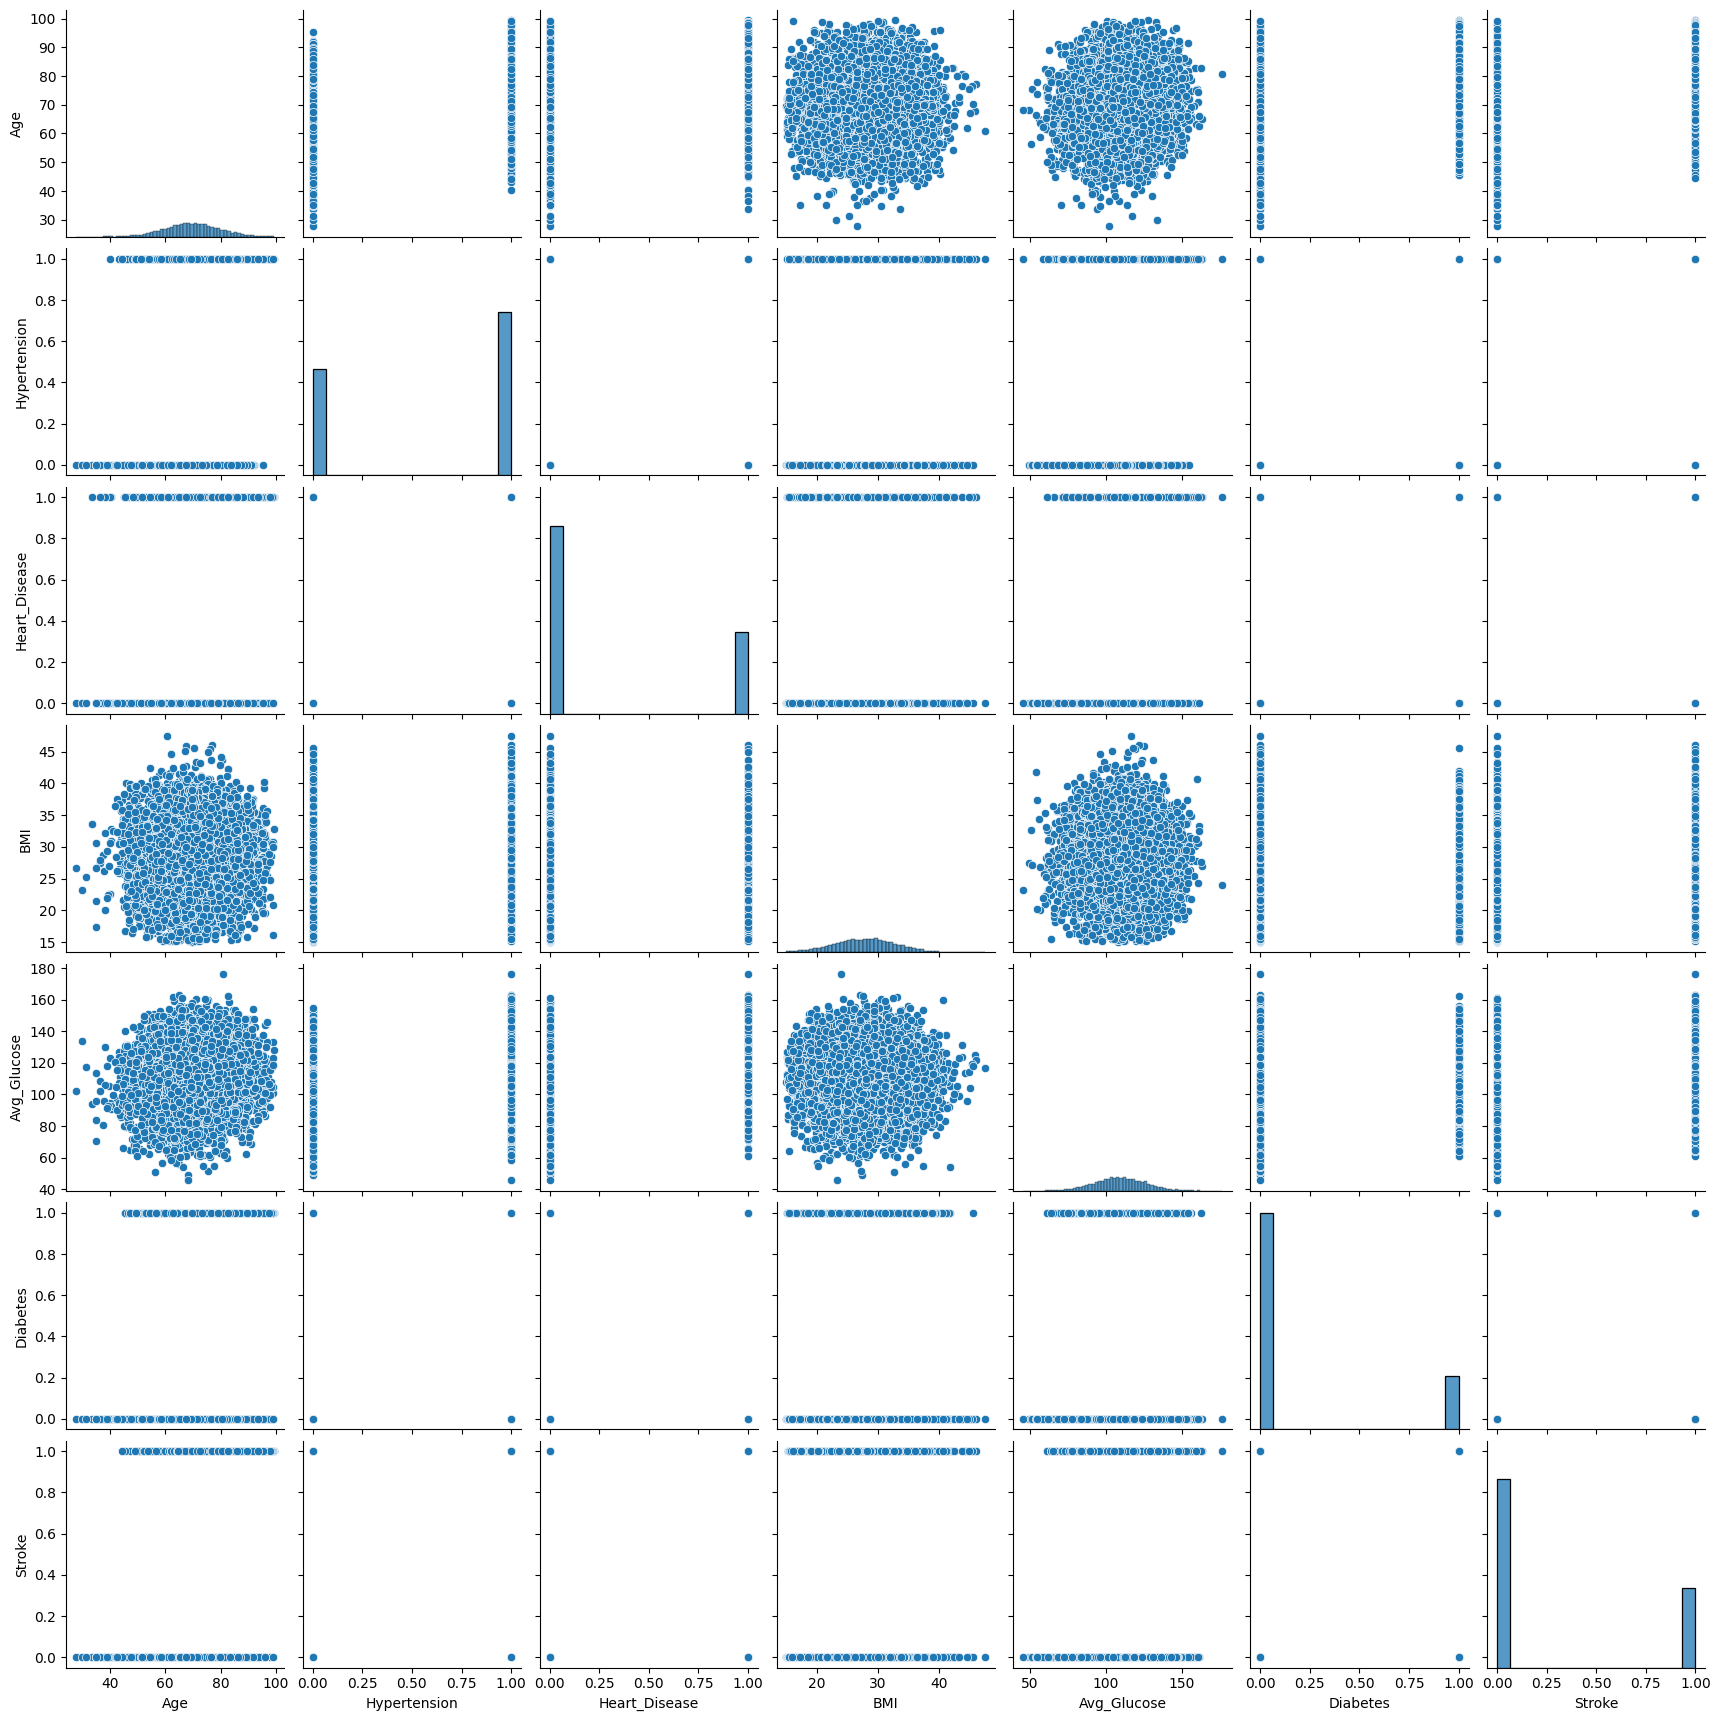

In [10]:
# Pairplot untuk fitur numerik
sns.pairplot(num_features)
plt.show()

<ipython-input-11-d3a6d7d8cdec>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data[column], palette='viridis')
<ipython-input-11-d3a6d7d8cdec>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data[column], palette='viridis')
<ipython-input-11-d3a6d7d8cdec>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data[column], palette='viridis')


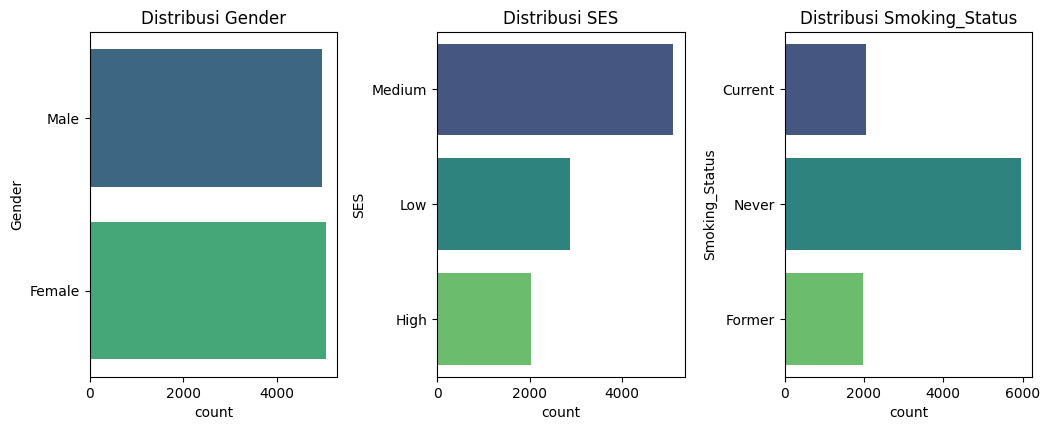

In [11]:
# Distribusi fitur kategorikal
cat_features = data.select_dtypes(include=[object])
plt.figure(figsize=(14, 8))
for i, column in enumerate(cat_features.columns, 1):
    plt.subplot(2, 4, i)
    sns.countplot(y=data[column], palette='viridis')
    plt.title(f'Distribusi {column}')
plt.tight_layout()
plt.show()

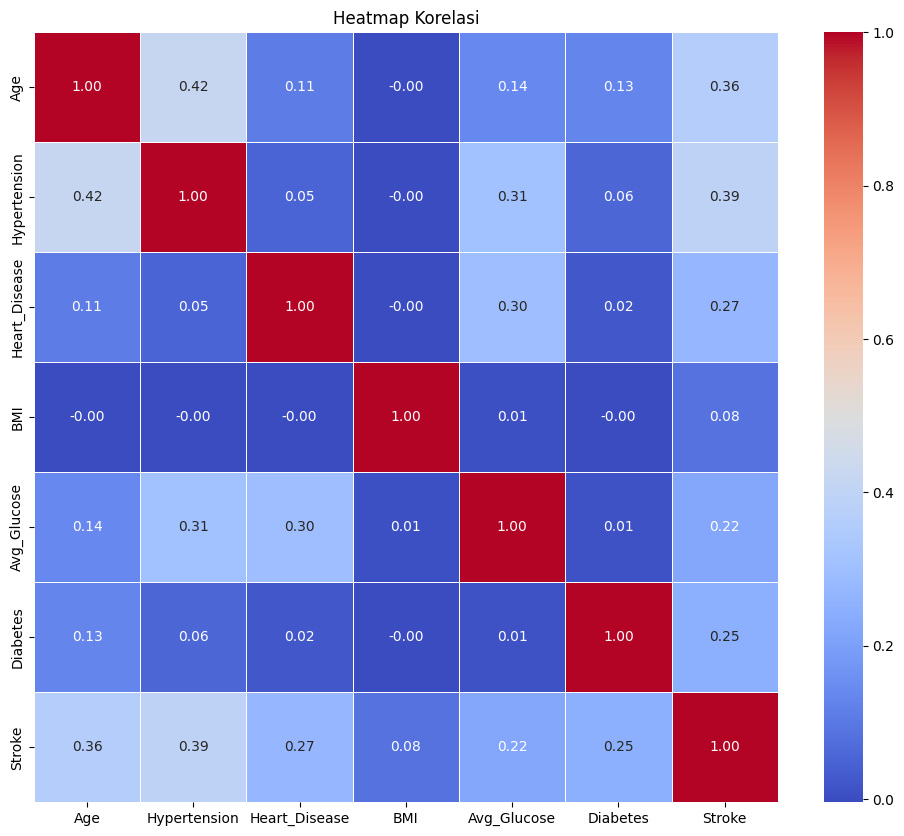

In [12]:
# Heatmap korelasi untuk fitur numerik
plt.figure(figsize=(12, 10))
correlation_matrix = num_features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap Korelasi')
plt.show()

Stroke paling berkorelasi dengan:
- Hypertension (0.39)
- Age (0.36)
- Heart Disease (0.27)
- Korelasi lainnya relatif lemah.

BMI tampaknya tidak berkorelasi signifikan dengan fitur lain (semua hampir 0).

<ipython-input-13-00550285f16c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Stroke', data=data, palette='viridis')


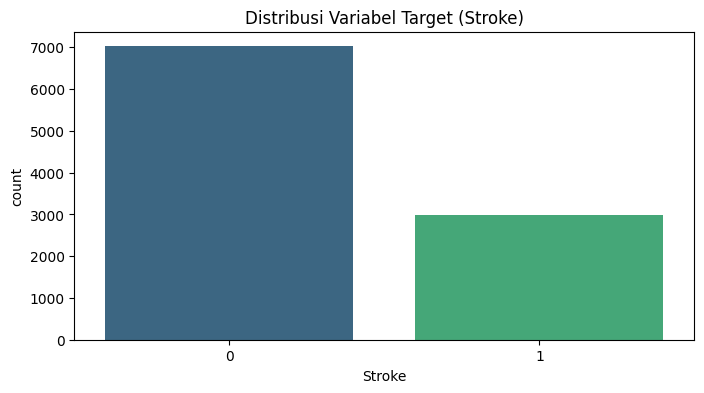

In [13]:
# Visualisasi distribusi variabel target
plt.figure(figsize=(8, 4))
sns.countplot(x='Stroke', data=data, palette='viridis')
plt.title('Distribusi Variabel Target (Stroke)')
plt.show()

In [14]:
# Menampilkan statistik deskriptif dari dataset
data.describe(include="all")

,Age,Gender,SES,Hypertension,Heart_Disease,BMI,Avg_Glucose,Diabetes,Smoking_Status,Stroke
count,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000,10000.000000
unique,NaN,2,3,NaN,NaN,NaN,NaN,NaN,3,NaN
top,NaN,Female,Medium,NaN,NaN,NaN,NaN,NaN,Never,NaN
freq,NaN,5037,5106,NaN,NaN,NaN,NaN,NaN,5951,NaN
mean,69.757847,NaN,NaN,0.605800,0.302800,28.042252,109.115918,0.196000,NaN,0.297800
std,9.869468,NaN,NaN,0.488703,0.459492,4.901424,16.421142,0.396988,NaN,0.457314
min,27.706561,NaN,NaN,0.000000,0.000000,15.037988,45.569135,0.000000,NaN,0.000000
25%,63.128574,NaN,NaN,0.000000,0.000000,24.660786,98.188349,0.000000,NaN,0.000000
50%,69.796042,NaN,NaN,1.000000,0.000000,28.066932,109.022208,0.000000,NaN,0.000000
75%,76.402885,NaN,NaN,1.000000,1.000000,31.390170,120.341179,0.000000,NaN,1.000000


## **Pre-Processing**

### **Label Encoder**

In [15]:
# Buat instance LabelEncoder
label_encoder = LabelEncoder()

# List kolom kategorikal yang perlu di-encode
categorical_columns = ['Gender', 'SES', 'Smoking_Status']

# Encode kolom kategorikal
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])

# Tampilkan DataFrame untuk memastikan encoding telah diterapkan
data.head()

,Age,Gender,SES,Hypertension,Heart_Disease,BMI,Avg_Glucose,Diabetes,Smoking_Status,Stroke
0,66.788137,1,2,1,0,25.842521,96.428681,1,0,1
1,86.393609,0,2,1,1,32.531061,133.350068,0,2,1
2,76.158579,0,2,1,0,40.681244,111.489589,0,2,0
3,72.477870,0,1,0,1,33.003193,125.692465,0,1,0
4,59.881635,1,1,0,0,26.062443,123.218486,1,2,1


### **Scaling Feature**

In [16]:
# Buat instance MinMaxScaler
scaler = MinMaxScaler()

# Normalisasi semua kolom numerik
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Pisahkan fitur (X) dan target (y)
X = data.drop(columns=['Stroke'])
y = data['Stroke']

## **Data Splitting**

In [17]:
# Split data menjadi set pelatihan dan set uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tampilkan bentuk set pelatihan dan set uji untuk memastikan split
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")

Training set shape: X_train=(8000, 9), y_train=(8000,)
Test set shape: X_test=(2000, 9), y_test=(2000,)


In [18]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Setelah SMOTE:", np.bincount(y_train_smote))

Setelah SMOTE: [5609 5609]


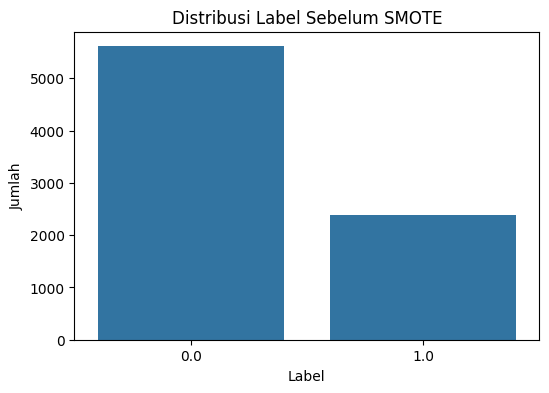

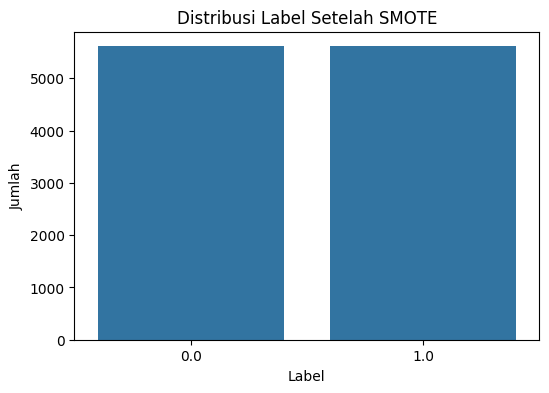

In [19]:
# Sebelum SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title("Distribusi Label Sebelum SMOTE")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.show()

# Sesudah SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_smote)
plt.title("Distribusi Label Setelah SMOTE")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.show()

## **Model Training**

### **Basic ML Model**

In [20]:
# Bagian 1: Pelatihan Model
# Definisikan setiap klasifikasi secara terpisah
knn = KNeighborsClassifier().fit(X_train_smote, y_train_smote)
dt = DecisionTreeClassifier().fit(X_train_smote, y_train_smote)
rf = RandomForestClassifier().fit(X_train_smote, y_train_smote)
svm = SVC().fit(X_train_smote, y_train_smote)
nb = GaussianNB().fit(X_train_smote, y_train_smote)

print("Model training selesai.")

Model training selesai.


### **Hyperparameter Tuning ML Model**

In [21]:
# Definisikan parameter grid untuk Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_smote, y_train_smote)

# Output hasil terbaik
print(f"Best parameters (Grid Search): {grid_search.best_params_}")
best_rf_grid = grid_search.best_estimator_

# Evaluasi performa model pada test set
grid_search_score = best_rf_grid.score(X_test, y_test)
print(f"Accuracy after Grid Search: {grid_search_score:.2f}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters (Grid Search): {'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy after Grid Search: 0.75


In [22]:
# Definisikan ruang pencarian untuk Random Search
param_dist = {
    'n_estimators': np.linspace(100, 500, 5, dtype=int),
    'max_depth': np.linspace(10, 50, 5, dtype=int),
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Inisialisasi RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train_smote, y_train_smote)

# Output hasil terbaik
print(f"Best parameters (Random Search): {random_search.best_params_}")
best_rf_random = random_search.best_estimator_

# Evaluasi performa model pada test set
random_search_score = best_rf_random.score(X_test, y_test)
print(f"Accuracy after Random Search: {random_search_score:.2f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters (Random Search): {'n_estimators': np.int64(500), 'min_samples_split': 2, 'max_depth': np.int64(50), 'criterion': 'gini'}
Accuracy after Random Search: 0.75


---

In [23]:
# Definisikan ruang pencarian untuk Bayesian Optimization
param_space = {
    'n_estimators': (100, 500),
    'max_depth': (10, 50),
    'min_samples_split': (2, 10),
    'criterion': ['gini', 'entropy']
}

# Inisialisasi BayesSearchCV
bayes_search = BayesSearchCV(estimator=rf, search_spaces=param_space, n_iter=32, cv=3, n_jobs=-1, verbose=2, random_state=42)
bayes_search.fit(X_train, y_train)

# Output hasil terbaik
print(f"Best parameters (Bayesian Optimization): {bayes_search.best_params_}")
best_rf_bayes = bayes_search.best_estimator_

# Evaluasi performa model pada test set
bayes_search_score = best_rf_bayes.score(X_test, y_test)
print(f"Accuracy after Bayesian Optimization: {bayes_search_score:.2f}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [24]:
param_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_knn, cv=5, scoring='accuracy')
grid_knn.fit(X_train_smote, y_train_smote)

print("KNN - Best params:", grid_knn.best_params_)


KNN - Best params: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}


In [25]:
param_dt = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_dt = GridSearchCV(DecisionTreeClassifier(), param_dt, cv=5, scoring='accuracy')
grid_dt.fit(X_train_smote, y_train_smote)

print("Decision Tree - Best params:", grid_dt.best_params_)


Decision Tree - Best params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}


In [26]:
param_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid_rf = GridSearchCV(RandomForestClassifier(), param_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train_smote, y_train_smote)

print("Random Forest - Best params:", grid_rf.best_params_)


Random Forest - Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150}


In [27]:
param_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(SVC(), param_svm, cv=5, scoring='accuracy')
grid_svm.fit(X_train_smote, y_train_smote)

print("SVM - Best params:", grid_svm.best_params_)


SVM - Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [28]:
param_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

grid_nb = GridSearchCV(GaussianNB(), param_nb, cv=5, scoring='accuracy')
grid_nb.fit(X_train_smote, y_train_smote)

print("Naive Bayes - Best params:", grid_nb.best_params_)


Naive Bayes - Best params: {'var_smoothing': 1e-09}


### **Tensorflow Model**

In [29]:
# TF Model
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_smote.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Training
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X_train_smote, y_train_smote,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6437 - auc: 0.6412 - loss: 0.6260 - val_accuracy: 0.6221 - val_auc: 0.0000e+00 - val_loss: 0.7722
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7491 - auc: 0.8074 - loss: 0.5141 - val_accuracy: 0.6640 - val_auc: 0.0000e+00 - val_loss: 0.6061
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7660 - auc: 0.8193 - loss: 0.5009 - val_accuracy: 0.6408 - val_auc: 0.0000e+00 - val_loss: 0.6787
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7641 - auc: 0.8197 - loss: 0.5016 - val_accuracy: 0.6537 - val_auc: 0.0000e+00 - val_loss: 0.6441
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7781 - auc: 0.8272 - loss: 0.4870 - val_accuracy: 0.6649 - val_auc: 0.0000e+00 - val_loss: 0.6228
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7646 - auc: 0.8327 - loss: 0.4875 - val_accuracy: 0.6520 - val_auc: 0.0000e+00 - val_loss: 0.6695
Epoch 7/50
281/

## **Model Evaluation**

### **Eval Basic Model**

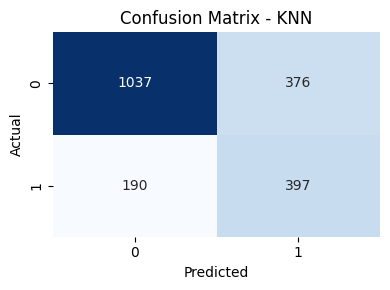

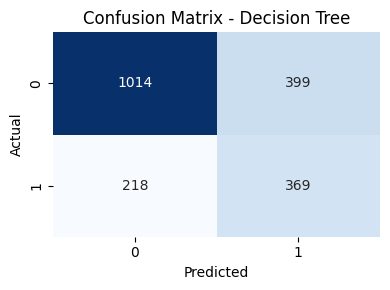

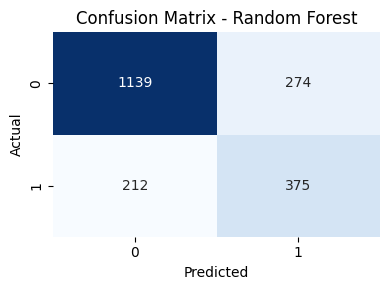

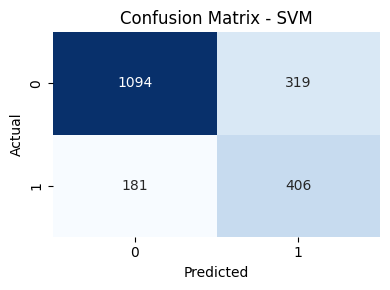

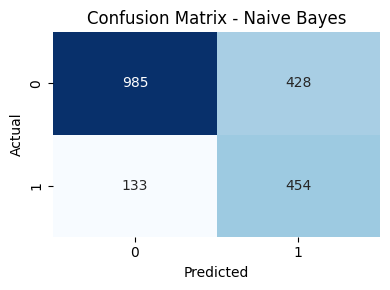

                          Model  Accuracy  Precision    Recall  F1-Score
0     K-Nearest Neighbors (KNN)    0.7170   0.513583  0.676320  0.583824
1            Decision Tree (DT)    0.6915   0.480469  0.628620  0.544649
2            Random Forest (RF)    0.7570   0.577812  0.638842  0.606796
3  Support Vector Machine (SVM)    0.7500   0.560000  0.691652  0.618902
4              Naive Bayes (NB)    0.7195   0.514739  0.773424  0.618108


In [38]:
# Fungsi untuk mengevaluasi dan menampilkan confusion matrix serta mengembalikan metrik
def evaluate_model(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)

    # Jika prediksi masih dalam bentuk probabilitas, ubah ke kelas
    if y_pred.ndim > 1 and y_pred.shape[1] > 1:
        y_pred = y_pred.argmax(axis=1)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Visualisasi Confusion Matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Kembalikan metrik evaluasi
    results = {
        'Confusion Matrix': cm,
        'True Positive (TP)': tp,
        'False Positive (FP)': fp,
        'False Negative (FN)': fn,
        'True Negative (TN)': tn,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }
    return results

# Mengevaluasi setiap model dan menampilkan hasilnya
results = {
    'K-Nearest Neighbors (KNN)': evaluate_model(knn, X_test, y_test, 'KNN'),
    'Decision Tree (DT)': evaluate_model(dt, X_test, y_test, 'Decision Tree'),
    'Random Forest (RF)': evaluate_model(rf, X_test, y_test, 'Random Forest'),
    'Support Vector Machine (SVM)': evaluate_model(svm, X_test, y_test, 'SVM'),
    'Naive Bayes (NB)': evaluate_model(nb, X_test, y_test, 'Naive Bayes')
}

# Buat DataFrame ringkasan metrik
summary_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

rows = []
for model_name, metrics in results.items():
    rows.append({
        'Model': model_name,
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1-Score': metrics['F1-Score']
    })

summary_df = pd.DataFrame(rows)

# Tampilkan ringkasan evaluasi
print(summary_df)

### **Eval Hyperparameter Tuning ML Model**

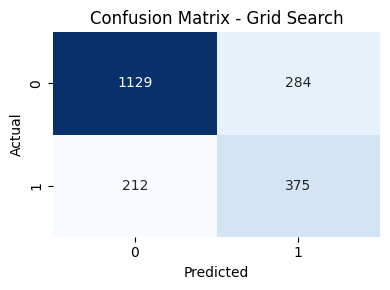

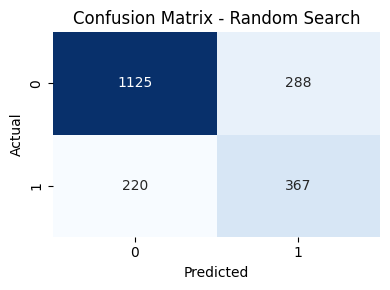

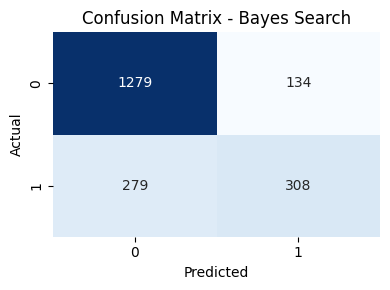

           Model  Accuracy  Precision    Recall  F1-Score
0    Grid Search    0.7520   0.569044  0.638842  0.601926
1  Random Search    0.7460   0.560305  0.625213  0.590982
2   Bayes Search    0.7935   0.696833  0.524702  0.598639


In [40]:
# Fungsi untuk mengevaluasi dan menampilkan confusion matrix serta mengembalikan metrik
def evaluate_model(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)

    # Jika prediksi masih dalam bentuk probabilitas, ubah ke kelas
    if y_pred.ndim > 1 and y_pred.shape[1] > 1:
        y_pred = y_pred.argmax(axis=1)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Visualisasi Confusion Matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Kembalikan metrik evaluasi
    results = {
        'Confusion Matrix': cm,
        'True Positive (TP)': tp,
        'False Positive (FP)': fp,
        'False Negative (FN)': fn,
        'True Negative (TN)': tn,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }
    return results

# Mengevaluasi setiap model dan menampilkan hasilnya
results = {
    'Grid Search': evaluate_model(best_rf_grid, X_test, y_test, 'Grid Search'),
    'Random Search': evaluate_model(best_rf_random, X_test, y_test, 'Random Search'),
    'Bayes Search': evaluate_model(best_rf_bayes, X_test, y_test, 'Bayes Search'),
}

# Buat DataFrame ringkasan metrik
summary_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

rows = []
for model_name, metrics in results.items():
    rows.append({
        'Model': model_name,
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1-Score': metrics['F1-Score']
    })

summary_df = pd.DataFrame(rows)

# Tampilkan ringkasan evaluasi
print(summary_df)

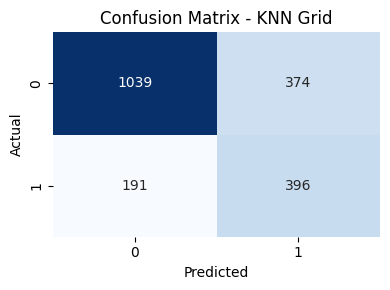

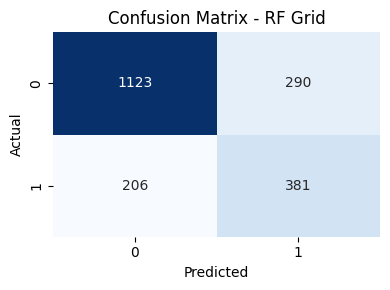

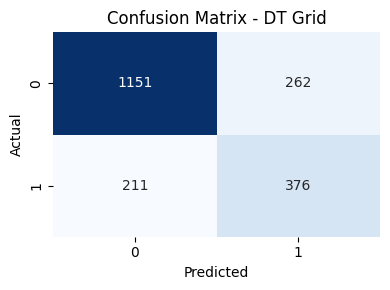

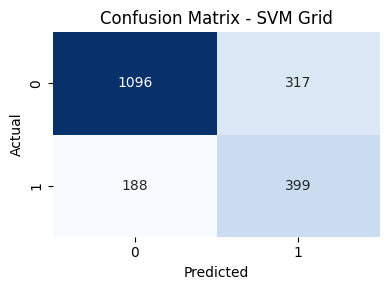

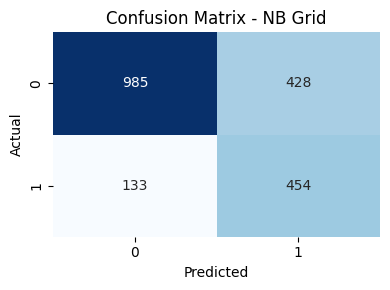

      Model  Accuracy  Precision    Recall  F1-Score
0  KNN Grid    0.7175   0.514286  0.674617  0.583640
1   RF Grid    0.7520   0.567809  0.649063  0.605723
2   DT Grid    0.7635   0.589342  0.640545  0.613878
3  SVM Grid    0.7475   0.557263  0.679727  0.612433
4   NB Grid    0.7195   0.514739  0.773424  0.618108


In [41]:
# Fungsi untuk mengevaluasi dan menampilkan confusion matrix serta mengembalikan metrik
def evaluate_model(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)

    # Jika prediksi masih dalam bentuk probabilitas, ubah ke kelas
    if y_pred.ndim > 1 and y_pred.shape[1] > 1:
        y_pred = y_pred.argmax(axis=1)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Visualisasi Confusion Matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Kembalikan metrik evaluasi
    results = {
        'Confusion Matrix': cm,
        'True Positive (TP)': tp,
        'False Positive (FP)': fp,
        'False Negative (FN)': fn,
        'True Negative (TN)': tn,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }
    return results

# Mengevaluasi setiap model dan menampilkan hasilnya
results = {
    'KNN Grid': evaluate_model(grid_knn, X_test, y_test, 'KNN Grid'),
    'RF Grid': evaluate_model(grid_rf, X_test, y_test, 'RF Grid'),
    'DT Grid': evaluate_model(grid_dt, X_test, y_test, 'DT Grid'),
    'SVM Grid': evaluate_model(grid_svm, X_test, y_test, 'SVM Grid'),
    'NB Grid': evaluate_model(grid_nb, X_test, y_test, 'NB Grid'),
}

# Buat DataFrame ringkasan metrik
summary_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

rows = []
for model_name, metrics in results.items():
    rows.append({
        'Model': model_name,
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1-Score': metrics['F1-Score']
    })

summary_df = pd.DataFrame(rows)

# Tampilkan ringkasan evaluasi
print(summary_df)

### **Eval Tensorflow Model**

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


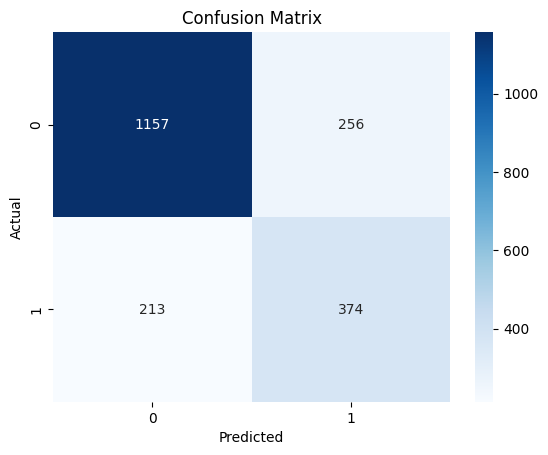

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.82      0.83      1413
         1.0       0.59      0.64      0.61       587

    accuracy                           0.77      2000
   macro avg       0.72      0.73      0.72      2000
weighted avg       0.77      0.77      0.77      2000



In [33]:
# TF Eval
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n", classification_report(y_test, y_pred))

## **Save Model**

In [48]:
# Dictionary model yang ingin diekspor
trained_models = {
    'stroke_rf_model_smote': rf,
    'stroke_rf_bayes_model_smote': best_rf_bayes,
    'stroke_dt_grid_model_smote': grid_dt,
    'stroke_tf_model_smote': model,
}

# Direktori penyimpanan
model_dir = 'exported_models'
os.makedirs(model_dir, exist_ok=True)  # Aman, tidak error jika folder sudah ada

# Looping ekspor model
for model_name, model_obj in trained_models.items():
    file_path = os.path.join(model_dir, f'{model_name}.pkl')
    joblib.dump(model_obj, file_path)
    print(f'Model "{model_name}" disimpan di: {file_path}')

# Menampilkan isi direktori untuk verifikasi
print('\nDaftar file dalam folder exported_models:')
!ls {model_dir}

Model "stroke_rf_model_smote" disimpan di: exported_models/stroke_rf_model_smote.pkl
Model "stroke_rf_bayes_model_smote" disimpan di: exported_models/stroke_rf_bayes_model_smote.pkl
Model "stroke_dt_grid_model_smote" disimpan di: exported_models/stroke_dt_grid_model_smote.pkl
Model "stroke_tf_model_smote" disimpan di: exported_models/stroke_tf_model_smote.pkl

Daftar file dalam folder exported_models:
dt_grid_model_smote.pkl		stroke_rf_bayes_model_smote.pkl
rf_bayes_model_smote.pkl	stroke_rf_model_smote.pkl
rf_model_smote.pkl		stroke_tf_model_smote.pkl
stroke_dt_grid_model_smote.pkl	tf_model_smote.pkl


## **Inferensi**

In [ ]:
X_train_smote.columns

Index(['Age', 'Gender', 'SES', 'Hypertension', 'Heart_Disease', 'BMI',
       'Avg_Glucose', 'Diabetes', 'Smoking_Status'],
      dtype='object')

In [53]:
# URL of the model on GitHub
url = "https://raw.githubusercontent.com/RiMedAI/laskarai-capstone/refs/heads/main/export-model/stroke_rf_bayes_model_smote.pkl"

# Fetch the model file from GitHub
response = requests.get(url)
response.raise_for_status()  # Raise an error if download failed

# Load the model from the response content
model = joblib.load(BytesIO(response.content))

# Inference data (ensure the features and data types match the model's training)
inference_data = {
    'Age': [67],
    'Gender': [1],
    'SES': [2],
    'Hypertension': [1],
    'Heart_Disease': [1],
    'BMI': [36.6],
    'Avg_Glucose': [228.69],
    'Diabetes': [1],
    'Smoking_Status': [1]
}

inference_df = pd.DataFrame(inference_data)

# Predict the class (0 or 1)
prediction = model.predict(inference_df)

# Predict the probability of each class (returns a 2D array with [prob_0, prob_1])
probabilities = model.predict_proba(inference_df)

# Get the probability of class 1 (heart disease) in percentage
prob_class_1 = probabilities[0][1] * 100

# Print the prediction and confidence
if prediction[0] == 1:
    print(f"The model predicts that the individual is likely to have stroke "
          f"with a confidence of {prob_class_1:.2f}%.")
else:
    print(f"The model predicts that the individual is unlikely to have stroke "
          f"with a confidence of {100 - prob_class_1:.2f}%.")

The model predicts that the individual is likely to have stroke with a confidence of 94.22%.
